What to do next time you are Here

- TO FIX :It seems some stances have a differient shape rather than a peak.



## Importing

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.svm import SVC

import os

from tqdm.auto import tqdm

import shutil

from itertools import groupby

import matplotlib.pyplot as plt

from statistics import mean

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis

from sklearn.model_selection import train_test_split

## Parameters

In [ ]:
# path of original data folder
data_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data"
# path of csv files, each file is a 2mins walk for a subject
csvD_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/csv_files"
# In this file, the Null values are replaved with 0 in the HY scale - Null values were given to healthy control
demographics = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/Processed_data/demographics_HYprocessed.csv" 
dem_df = pd.read_csv(demographics)
# parequet folder path
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"

## Data Utils

#### trying


In [ ]:
a = [1, 0, 0, 1, 1, 1, 3, 0,
     1, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1,
     0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 5]

In [ ]:
right_phases = [list(g) for k, g in groupby((a), lambda x:x>0)]

In [ ]:
right_phases

[[1],
 [0, 0],
 [1, 1, 1, 3],
 [0],
 [1, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1],
 [0],
 [1],
 [0],
 [1, 1, 1],
 [0, 0, 0],
 [1, 5]]

In [ ]:
indices=[0]

In [ ]:
for i in range(1, len(right_phases),2):
  indices.append(indices[-1]+len(right_phases[i]) + len(right_phases[i-1]))

In [ ]:
indices

[0, 3, 8, 20, 22, 28]

In [ ]:
gait_cycles= [a[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
gait_cycles

[[1, 0, 0],
 [1, 1, 1, 3, 0],
 [1, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1, 0],
 [1, 0],
 [1, 1, 1, 0, 0, 0]]

In [ ]:
stride_time=  [((len(gait_cycles[i])  -1)*0.01 ) for i in range(len(gait_cycles))]
stride_time

[0.02, 0.04, 0.11, 0.01, 0.05]

In [ ]:
stride_time =  [((len(right_phases[i]) + len(right_phases[i-1]) -1)*0.01 ) for i in range(1,len(right_phases),2)]
stride_time 

[0.02, 0.04, 0.11, 0.01, 0.05]

In [ ]:
right_stances = [l for l in right_phases if any(l)]


In [ ]:
right_stances

[[1], [1, 1, 1, 3], [1, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1], [1], [1, 1, 1], [1, 5]]

In [ ]:
time_stance = [(len(l)-1)*0.01 for l in right_stances]
time_stance

[0.0, 0.03, 0.1, 0.0, 0.02, 0.01]

In [ ]:
time_stance = [(len(l)-1)*0.01 for l in right_phases if any(l)]
time_stance

[0.0, 0.03, 0.1, 0.0, 0.02, 0.01]

In [ ]:
right_swings = [l for l in right_phases if not all (l)]
swings_time = [(len(l)-1)*0.01 for l in right_phases if not all (l)]

In [ ]:
right_swings

[[0, 0], [0], [0], [0], [0, 0, 0]]

In [ ]:
swings_time

[0.01, 0.0, 0.0, 0.0, 0.02]

In [ ]:
features=np.arange(1, 19)
features

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

#### Data Class

Note: 
Gait cycle = stride cycle


- Usually, Vertical Ground React Force VGRF values less than 20N are generated from noise
- For gait cycle segmentation, to eliminate the effect of gait initiation and termenation, the first and last 20 seconds of VGRF data was discarded.
- Note: Since we are deleting the first and last 20 seconds, some patients that performed less than 2 mins have almost no gait cycles left. For example, the paient with Id `JuCo02` and `JuCo03` walked for almost 40.40 seconds. Thus, after deleting the first and last 20 sec, he has only half gait cycle left. 

*   stride time variability and swing time variability are important parameters in distinguishing a PD patient’s gait from normal gait.
*   As PD patients tend to put less pressure during placing the heel strike and toe off than control subjects, maximum VGRF at heel strike and toe off for each gait cycle was computed. The mean and standard deviation of the VGRF overall gait cycles were taken as features for classification.




In [ ]:
r_stances=np.arange(1,10)
print(r_stances)
r_stances = r_stances[:-1]
print(r_stances)

[1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 6 7 8]


In [ ]:
class Data:
  def __init__(self, prepare_or_get, data_folder, demographics_file, parquet_path):
    '''
    :param prepare_or_get:  1: prepare data , 0: load preloaded datas (npy)
    :param data_folder: path for a folder containing csv files, file for each 2 mins walk (for indivdiual subject)
    :param demographics_file: path for csv demographics file
    :save_path: path where to save/read parquet files after preparing them
    :
    '''

    self.data_path = data_folder
    self.parquet_path= parquet_path
    self.dem_path= demographics_file
    self.scale="HoehnYahr"            # fixed for now
    self.seconds_to_discard = 20      # fixed for now
    self.rows_to_discard = 100 * self.seconds_to_discard
    
    # data in arrays
    self.signals_data = []
    self.cycles_data=[]
    self.statical_data=[]
  

    if (prepare_or_get==1):
      self.prepare_data()
    elif (prepare_or_get==0):
      self.get_data()
  
  def get_data(self):
    self.signals_data_df= pd.read_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df=pd.read_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df=pd.read_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df=pd.read_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df=pd.read_parquet(self.parquet_path+'right_stances.gzip')

  def prepare_data(self):
    # loop over files, each file is a 2 min walk for a single individual
    # files are expected to be in csv format
    self.dem_df = pd.read_csv(self.dem_path)
    for name in tqdm((os.listdir(self.data_path))):
       
      # id of subject
      id = name.split('_')[0]

      # disease level according to 'self.scale'
      level = self.get_pd_level( id)

      # parkinon's patient OR healthy control ?
      if 'Co' in name:  
        parkinson = 0 # Healthy control
      elif 'Pt' in name:
        parkinson = 1 # Parkinson's Patient

      # read and filter one file
      one_walk=self.read_filter(name)

      # sum of values from all the left sensors
      one_walk['Total_Force_Left'] = one_walk[list(one_walk.columns[0:8])].sum(axis=1)
     
      # sum of values from all the right sensors
      one_walk['Total_Force_Right'] = one_walk[list(one_walk.columns[8:16])].sum(axis=1)
      
      # convert to lists
      one_walk_lists=[]*18
      for column in one_walk.columns.values.tolist():
        one_walk_lists.append(one_walk[column].tolist()) 

      ## Left foot related ##
      l_stances, l_strides_time , l_swings_time, l_stances_time, l_indices = self.segment_signal(one_walk_lists[16])
      # Find maximum VGRF at heel strike for each gait cycle 
      l_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[0],l_indices) # sensor 0 = left heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      l_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[7],l_indices) # sensor 7 = left toe sensor

      ## right foot related ##
      r_stances, r_strides_time , r_swings_time, r_stances_time, r_indices = self.segment_signal(one_walk_lists[17])
      # Find maximum VGRF at heel strike for each gait cycle 
      r_peaks_heel = self.get_max_per_gait_cycle(one_walk_lists[8],l_indices) # sensor 8 = right heal sensor
      # Find maximum VGRF at toe off for each gait cycle
      r_peaks_toe = self.get_max_per_gait_cycle(one_walk_lists[15],l_indices) # sensor 15 = right toe sensor


      ## Saving data ##

      # Raw Signals
      self.signals_data.append([id,level,parkinson] +one_walk_lists)

      # Statical
      self.statical_data.append( [ id, level, parkinson 
                                , mean (l_swings_time) , np.std(l_swings_time), (mean (l_swings_time) / np.std(l_swings_time) *100)
                                , mean (l_strides_time) , np.std(l_strides_time) , (mean (l_strides_time) / np.std(l_strides_time)*100)
                                , kurtosis(l_strides_time), skew(l_strides_time)
                                , mean (l_stances_time) , np.std(l_stances_time) , ( mean (l_stances_time) / np.std(l_stances_time) *100) 

                                , mean (r_swings_time) , np.std(r_swings_time), (mean (r_swings_time) / np.std(r_swings_time) *100)
                                , mean (r_strides_time) , np.std(r_strides_time) , (mean (r_strides_time) / np.std(r_strides_time)*100)
                                , kurtosis(r_strides_time), skew(r_strides_time)
                                , mean (r_stances_time) , np.std(r_stances_time) , ( mean (r_stances_time) / np.std(r_stances_time) *100)
                                
                                , mean (l_peaks_heel) , np.std(l_peaks_heel) ,mean (l_peaks_toe) , np.std(l_peaks_toe)
                                , mean (r_peaks_heel) , np.std(r_peaks_heel) ,mean (r_peaks_toe) , np.std(r_peaks_toe)
                                  ] )
      
      
      # Segmented Signals
      
      # NEED TO BE MOVED TO SEPERATE FUNCTION
      # only for segmented data, for a trial we need each stance phase with the following 
      # swing phases's time, so here we are adjusting the phases to be equal

      dif_l =  len(l_stances)-len(l_swings_time)
      if (dif_l > 0):
        l_stances=l_stances[:-dif_l]
      elif(dif_l < 0):
        l_swings_time= l_swings_time[:dif_l]

      
      dif_r =  len(r_stances)-len(r_swings_time)
      if (dif_r>0):
        r_stances=r_stances[:-dif_r]
      elif(dif_r < 0):
        r_swings_time = r_swings_time[:dif_r]
       
      self.cycles_data.append( [ id, level, parkinson ] 
                              + [l_stances] + [l_strides_time] + [l_swings_time] + [l_stances_time]
                              + [r_stances] + [r_strides_time] + [r_swings_time] + [r_stances_time]
                              + [l_peaks_heel] + [l_peaks_toe]
                              + [r_peaks_heel] + [r_peaks_toe]
                              )
      

    self.statical_data_to_df()
    self.cycles_data_to_df()
    self.signal_data_to_df()
    ## Get individual stances data frames
    self.ind_stances_to_df()
    ## writing files ##
    self.save_files()

  def get_pd_level(self, subject_id):
    level = self.dem_df[self.scale][dem_df['ID'] == subject_id ].values[0]
    return level

  def read_filter(self,name):
      # Reading each file, skipping 3 columns (time,total right forces & total left forces)
      # For gait cycle segmentation, to eliminate the effect of gait initiation and termenation,
      # the first and last N=20 seconds of VGRF data was discarded.

      one_walk = pd.read_csv(self.data_path + '/' + name,
                             skiprows=list(range(1,self.rows_to_discard+1)) ,
                             skipfooter=self.rows_to_discard,
                             usecols = np.arange(1,17),
                             engine = 'python')  
      
      # Usually, Vertical Ground React Force VGRF values less than 20N are generated from noise
      one_walk.where(one_walk > 20, 0, inplace=True)

      return one_walk

  def segment_signal(self, signal):
      # swing - stance phases repeatly
      phases = [list(g) for k, g in groupby((signal), lambda x:x>0)]
      
      # Deleting the first and last phase, since the first and last 20 seconds were deleted,
      # there's no garanty that the first and last phase are complete
      # Hence, they are being deleted here just for safety

      phases = phases[1:-1]

      # filtering phases that is shorter than 20 becuase must propably it's noise
      phases = [l for l in phases if len(l)>20]

      # indices of the gait cycles
      indices=[0]
      for i in range(1, len(phases),2):
        indices.append(indices[-1]+len(phases[i]) + len(phases[i-1]))

      # stances phases
      stances = [l for l in phases if any(l)]
      
      # strides times 
      strides_time =  [((len(phases[i]) + len(phases[i-1]) -1)*0.01 ) for i in range(1,len(phases),2)]

      # swings time
      swings_time = [(len(l)-1)*0.01 for l in phases if not all (l)]

      # stance time 
      stances_time = [(len(l)-1)*0.01 for l in stances]

      return stances, strides_time , swings_time, stances_time, indices

  def get_max_per_gait_cycle(self, signal,indices):
    gait_cycles = self.get_gait_cycles(signal, indices)
    peaks = [max(cycle) for cycle in gait_cycles]
    return peaks

  def get_gait_cycles(self, signal, indices):
    # get gait cycles
    gait_cycles= [signal[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    return gait_cycles

  def signal_data_to_df(self):
    self.signals_data_df = pd.DataFrame(self.signals_data, columns =["ID", "level", "y", "L1", "L2","L3", "L4","L5","L6","L7","L8",
                                       "R1", "R2","R3", "R4","R5","R6","R7","R8","Total_Force_Right","Total_Force_Left" ])
     
    
  def cycles_data_to_df(self):
    self.cycles_data_df = pd.DataFrame(self.cycles_data, columns =["ID", "level", "y", 
                                                                   "l_stances", "l_strides_time", "l_swings_time" , "l_stances_time"
                                                                  , "r_stances" , "r_strides_time" , "r_swings_time" , "r_stances_time"
                                                                  , "l_peaks_heel" , "l_peaks_toe"
                                                                  , "r_peaks_heel" , "r_peaks_toe" ])
    

  def statical_data_to_df(self):
    self.statical_data_df = pd.DataFrame(self.statical_data, columns =["ID", "level", "y"
                                                                      , "mean_left_swings_time" , "std_left_swings_time", "cv_left_swings_time"
                                                                      , "mean_left_stride_time" , "std_left_stride_time" ,"cv_left_stride_time"
                                                                      , "kurtosis_left_strides_time", "skew_left_strides_time"
                                                                      , "mean_left_stance_time" , "std_left_stance_time", "cv_left_stance_time"
                                                                      , "mean_right_swings_time" , "std_right_swings_time", "cv_right_swings_time"
                                                                      , "mean_right_stride_time" , "std_right_stride_time", "cv_right_stride_time"
                                                                      , "kurtosis_right_strides_time", "skew_right_strides_time"
                                                                      , "mean_right_stance_time" , "std_right_stance_time", "cv_right_stance_time"
                                                                      , "mean_left_peaks_heel" , "std_left_peaks_heel"
                                                                      , "mean_left_peaks_toe" , "std_left_peaks_toe"
                                                                      , "mean_right_peaks_heel" , "std_right_peaks_heel"
                                                                      , "mean_right_peaks_toe" , "std_right_peaks_toe"
                                                                       ])
  def ind_stances_to_df(self):
    #droping NNOT WORKING HERE
    self.left_stances_df = self.cycles_data_df.explode(["l_stances","l_swings_time"])
    self.left_stances_df = self.left_stances_df.drop(columns=["r_stances" ,	"r_strides_time" ,	"r_swings_time" ,	"r_stances_time", "r_peaks_heel" ,	"r_peaks_toe"], axis=1)

    self.right_stances_df = self.cycles_data_df.explode(["r_stances","r_swings_time"])
    self.right_stances_df = self.right_stances_df.drop(columns=["l_stances" ,	"l_strides_time" ,	"l_swings_time" ,	"l_stances_time", "l_peaks_heel" ,	"l_peaks_toe"], axis=1)

  def save_files(self):
    self.signals_data_df.to_parquet(self.parquet_path+'signals.gzip')
    self.cycles_data_df.to_parquet(self.parquet_path+'cyclels.gzip')
    self.statical_data_df.to_parquet(self.parquet_path+'statical.gzip')
    self.left_stances_df.to_parquet(self.parquet_path+'left_stances.gzip')
    self.right_stances_df.to_parquet(self.parquet_path+'right_stances.gzip')

### Prepare the data

In [ ]:
data = Data( 1, csvD_path, demographics,parquet_path)

  0%|          | 0/304 [00:00<?, ?it/s]

In [ ]:
data.cycles_data_df

### Read already prepared data

In [ ]:
data_df = Data( 0, "", "",parquet_path)

In [ ]:
type(data_df.signals_data_df["L1"].iloc[-1]) 

numpy.ndarray

In [ ]:
data=data_df

### Example

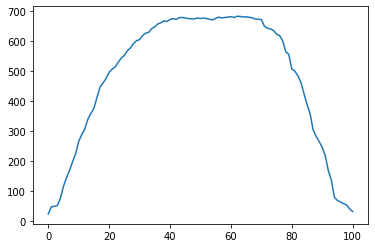

In [ ]:
# example of one stance phase 
y = data_df.left_stances_df['l_stances'].iloc[7]
import matplotlib.pyplot as plt
plt.plot(y)

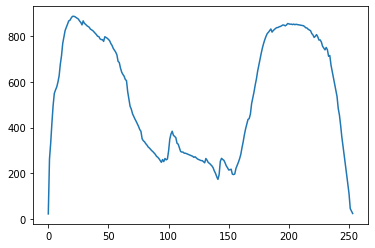

In [ ]:
# example of one stance phase 
y = data_df.left_stances_df['l_stances'].iloc[9000]
import matplotlib.pyplot as plt
plt.plot(y)

### FWHM


In [ ]:
def fwhm(y_values_temp, x_values):
    y_values, temp_l, temp_r = [], [], []
    ## print(y_values_temp, x_values)
    # To make 'y_values_temp', a numpy array, into a python list
    for x in range(0,len(y_values_temp)):
        y_values.append(y_values_temp[x])
    peak_height = max(y_values)
    half_peak_height = max(y_values)/2
    
    # Splitting the y_values data into before and after x_value at peak height
    y_l_temp = y_values[0:y_values.index(peak_height)]
    y_r_temp = y_values[y_values.index(peak_height):len(y_values)]
    
    # Finds 1st closest value to half_peak_height in y_l and y_r
    y_l = [abs(x-half_peak_height) for x in y_l_temp] # the distances
    y_l_min = min(y_l)
    point_left=y_l_temp[y_l.index(y_l_min)]  
    
    y_r = [abs(x-half_peak_height) for x in y_r_temp] # the distances
    point_right=y_r_temp[y_r.index(min(y_r))]  
    
    # y_l = nsmallest(1, y_l_temp, key=lambda x: abs(x-half_peak_height))
    # y_r = nsmallest(1, y_r_temp, key=lambda x: abs(x-half_peak_height))
    
    # Gets x_value pairs for y_l and y_r
    temp_l.append(x_values[y_l_temp.index(point_left)])
    temp_r.append(x_values[y_r_temp.index(point_right)])
    fwhm_n = temp_l[0] - temp_r[0]
    return abs(fwhm_n)

In [ ]:
# data.left_stances_df.drop(index=data.left_stances_df.index[0], axis=0, inplace=True)

In [ ]:
data.left_stances_df.head()

In [ ]:
data.right_stances_df['max_peak'] = data.right_stances_df['r_stances'].apply(lambda x: max(x))

In [ ]:
i=0

In [ ]:
len(data.right_stances_df['r_stances'].iloc[28])

100

In [ ]:
data.right_stances_df['FWHM'] = data.right_stances_df['r_stances'].apply(lambda x: fwhm(x, np.arange(0, len(x)*0.01,0.01)))

In [ ]:
data.right_stances_df.head()

,ID,level,y,r_stances,r_strides_time,r_swings_time,r_stances_time,r_peaks_heel,r_peaks_toe,max_peak,FWHM
0,GaPt03,3.0,1,"[20.79, 27.72, 32.45, 37.07, 63.69, 110.33, 13...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.39,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",731.61,0.48
0,GaPt03,3.0,1,"[52.8, 69.19, 57.64, 51.7, 60.94, 92.84, 140.1...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.21,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",774.73,0.20
0,GaPt03,3.0,1,"[23.1, 32.45, 39.38, 46.31, 116.82, 155.43, 17...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",717.75,0.05
0,GaPt03,3.0,1,"[23.1, 41.69, 55.55, 119.13, 154.55, 200.42, 2...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.43,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",742.50,0.10
0,GaPt03,3.0,1,"[25.41, 37.07, 55.55, 106.37, 152.02, 182.05, ...","[1.59, 1.27, 1.41, 1.49, 1.56, 1.41, 1.5, 1.32...",0.41,"[1.19, 1.05, 0.99, 1.05, 1.1400000000000001, 0...","[107.8, 71.17, 111.1, 141.24, 101.2, 123.42, 1...","[80.63, 134.42, 80.63, 71.61, 98.78, 130.02, 8...",779.79,0.17


### Scaling


In [ ]:
def fxy(x, y):
  return np.asarray(x) * 0.20 

In [ ]:
data.right_stances_df['transformed_signal'] = data.right_stances_df.apply(lambda x: fxy(x['r_stances'], x['FWHM']), axis=1)

### Just to check, after scaling

In [ ]:
x = np.arange(0, len(y)*0.01,0.01)

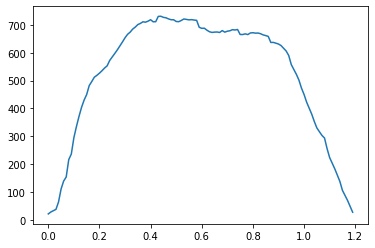

In [ ]:
# example of one stance phase 
y = data.right_stances_df['r_stances'].iloc[0]
import matplotlib.pyplot as plt

plt.plot(x,y)

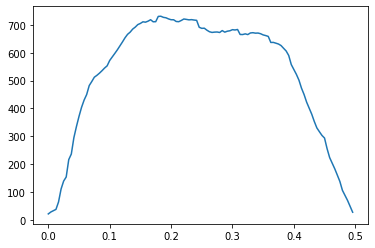

In [ ]:
y = data.right_stances_df['r_stances'].iloc[0]
x = np.arange(0, len(y)*0.01,0.01) * 0.20 /0.48
# example of one stance phase 

import matplotlib.pyplot as plt
plt.plot(x,y)

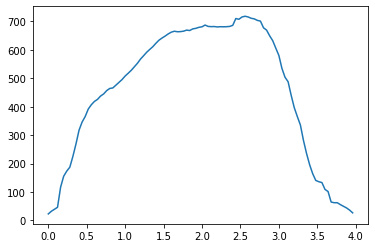

In [ ]:
y = data.right_stances_df['r_stances'].iloc[2]
x = np.arange(0, len(y)*0.01,0.01) 
# example of one stance phase 

import matplotlib.pyplot as plt
plt.plot(x,y)

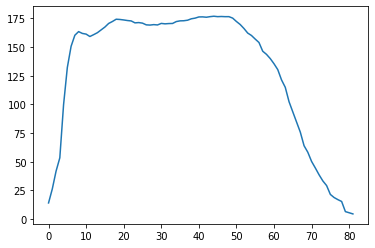

In [ ]:
# example of one stance phase 
y = data.right_stances_df['transformed_signal'].iloc[9500]
import matplotlib.pyplot as plt
plt.plot(y)

### Trying FWHM algorithm

In [ ]:
pip install specutils

In [ ]:
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi

In [ ]:
fwhm() 

In [ ]:
from matplotlib import pyplot as mp
import numpy as np

def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

# make some fake data
x=np.linspace(0,len(y),21)
y=peak(y,10)

# find the two crossing points
hmx = half_max_x(x,y)

# print the answer
fwhm = hmx[1] - hmx[0]
print("FWHM:{:.3f}".format(fwhm))

# a convincing plot
half = max(y)/2.0
mp.plot(x,y)
mp.plot(hmx, [half, half])
mp.show()

## SVM models


### SVM


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.statical_data_df.iloc[:, 3:], data.statical_data_df["y"], test_size=0.33, random_state=42)

In [ ]:
svc = SVC(kernel='poly').fit(X_train, y_train)

In [ ]:
svc.score(X_test, (y_test))

0.7524752475247525

### SVM 2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.statical_data_df[["mean_left_swings_time" , "std_left_swings_time", "cv_left_swings_time"
                                                                      , "mean_left_stride_time" , "std_left_stride_time" ,"cv_left_stride_time"
                                                                      , "kurtosis_left_strides_time", "skew_left_strides_time"
                                                                      , "mean_left_stance_time" , "std_left_stance_time", "cv_left_stance_time"
                                                                      
                                                                      , "mean_left_peaks_heel" , "std_left_peaks_heel"
                                                                      , "mean_left_peaks_toe" , "std_left_peaks_toe"]],
                                                    data.statical_data_df["y"], 
                                                    test_size=0.33, random_state=42)

In [ ]:
svc = SVC(kernel='poly').fit(X_train, y_train)

In [ ]:
svc.score(X_test, (y_test))

0.7128712871287128

### SVM3

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.statical_data_df[[ "cv_left_swings_time" ,"cv_left_stride_time"
                                                                      
                                                                      , "mean_left_peaks_heel" , "std_left_peaks_heel"
                                                                      , "mean_left_peaks_toe" , "std_left_peaks_toe"]],
                                                    data.statical_data_df["y"], 
                                                    test_size=0.33, random_state=42)

In [ ]:
svc = SVC(kernel='poly').fit(X_train, y_train)

In [ ]:
svc.score(X_test, (y_test))

0.7128712871287128

### SVM 4

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.statical_data_df[["cv_right_swings_time", "cv_right_stride_time"
                                                                      , "mean_right_peaks_heel" , "std_right_peaks_heel"
                                                                      , "mean_right_peaks_toe" , "std_right_peaks_toe"
                                                                       ]],
                                                    data.statical_data_df["y"], 
                                                    test_size=0.33, random_state=42)

In [ ]:
svc = SVC(kernel='poly').fit(X_train, y_train)

In [ ]:
svc.score(X_test, (y_test))

0.693069306930693